# Amazon Fine Food Reviews Analysis

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### Objective:
T-SNE visualization of Amazon reviews with polarity based color-coding (that means predicting wheater review is positive or not)

# Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

con = sqlite3.connect('database.sqlite') #connecting to 'database.sqlite' and reading data from it 

filter_amz_data = pd.read_sql_query(""" 
SELECT *
FROM Reviews
WHERE Score != 3
""", con) # taking only those reviews having score greater than 3(4,5) and less than 3(1,2) not taking reviews of score 3


def partition_positive_negative(x): # Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filter_amz_data['Score']
positiveNegative = actualScore.map(partition_positive_negative) #map() will maps inputs of 'actualscore' using function partition
filter_amz_data['Score'] = positiveNegative

In [2]:
sample_amz_data = filter_amz_data.head(15000) #Sampled amazon fine foood reviews filtered data to 15k datapoints for time effiecieny

#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication


In [3]:
#Sorting data according to ProductId in ascending order; sorting is necessary because if duplicates entries are there than we want to have only one of it and that we get from first entry of duplicates entries after sorting

sorted_data = sample_amz_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

**sorting is necessary because if duplicates entries are there than we want to have only one of it and that we get from first entry of duplicates entries after sorting**

In [4]:
#Deduplication of entries

final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(sorted_data.shape) 
print(final.shape)

(15000, 10)
(14470, 10)


**As we can see that in sorted_data there are 15k points but now after removing duplicates entries we git some 14k points**

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
# It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator 
#which is not practically possible hence these two rows too are removed from calcualtions

In [6]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(14470, 10)


positive    12187
negative     2283
Name: Score, dtype: int64

##  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [7]:
import re
import nltk
import string
from nltk.corpus import stopwords # nltk- natural language processing toolkit
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [8]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values: #taking each reviews
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split(): # taking each words of each reviews
        for cleaned_words in cleanpunc(w).split(): #cleanpunc(w) will remove any punctuations/special symbols from each word
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):   #checking word should be only have alphabets not aplha-numeric/numeric and all words should have length >2 
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8') #returing each word to be in lower case
                    filtered_sentence.append(s) # appending each filtered word of reviews to the list
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)
    i+=1

# Text feature extraction

Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.

We call <b>vectorization</b> the general process of turning a collection of text documents into numerical feature vectors. 

<b><h1>Techniques for vectorization :--</h1> </b>

# (1) Bag of Words (BoW)

In [9]:
l=final['Score'] #taking postive/negative reviews labels
labels = l.head(15000) # and sampling only 15k labels

print("the shape of sample data = ", final['Text'].shape)


the shape of sample data =  (14470,)


In [347]:
# Bag of Words (Bow)

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer() #in scikit-learn , just initalizing
final_counts = count_vect.fit_transform(final['Text'].values) # computing Bow
print(type(final_counts))

<class 'scipy.sparse.csr.csr_matrix'>


In [348]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import MaxAbsScaler
standardized_data = MaxAbsScaler().fit_transform(final_counts).todense()
print(standardized_data.shape)

(14470, 23233)


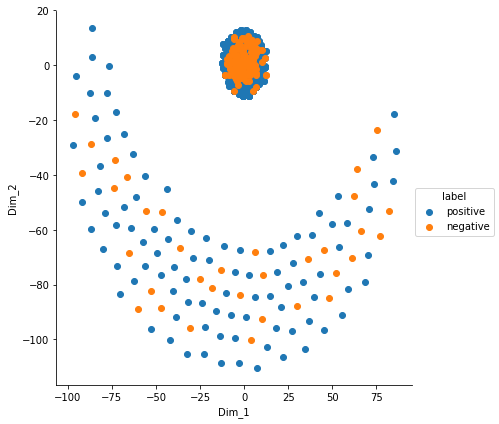

In [351]:
# TSNE
import seaborn as sn
from sklearn.manifold import TSNE

# Picking the top 2k points as TSNE takes a lot of time for 15K points
data_2000 = standardized_data[0:2000,:]
labels_2000 = labels[0:2000]

model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

<b>Observation(s):-</b>

1. We observe in this t-sne plot that on taking 2k datapoints, both class label(positive class and negative class) data points are not that much clearly separable by which we cannot make model to classify both class datapoints.

2. And we also see that lot of data points of both classes between interval -25 to +25 are most of them overlapped.

3. Between interval -100 to +75 on x-axis lot of blue points(positive class datapoints) are distibuted in U-shaped structure and few orange points (negative class datapoints) are spreaded amoung blue points that means very difficult to separate those points to make classification easier.


# (2) TF-IDF 

In [10]:
d=final['Text']
data_tfidf=d.head(5000)

In [11]:
#tf-idf

from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
final_tf_idf = tf_idf_vect.fit_transform(data_tfidf)
print(final_tf_idf.shape)

(5000, 14337)


In [16]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import MaxAbsScaler
standardized_data_tfidf = MaxAbsScaler().fit_transform(final_tf_idf).todense()
print(standardized_data_tfidf.shape)

(5000, 154530)


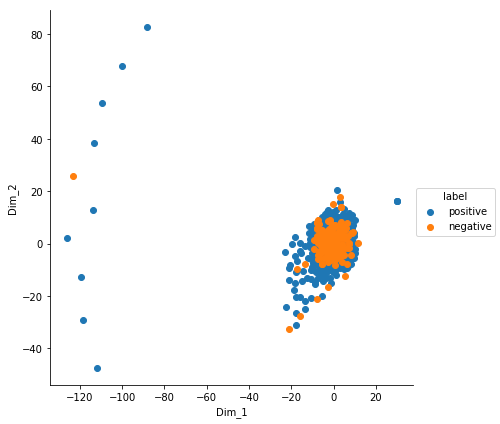

In [22]:
# TSNE
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Picking the top 2k points as TSNE takes a lot of time for 5K points
data_2000 = standardized_data_tfidf[0:2000,:]
labels_2000 = labels[0:2000]

model = TSNE(n_components=2, random_state=0)

tsne_data_tfidf = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data_tfidf = np.vstack((tsne_data_tfidf.T, labels_2000)).T
tsne_df_tfidf = pd.DataFrame(data=tsne_data_tfidf, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df_tfidf, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

<b>Observation(s):-</b>

1. As we have sampled dataset to only 5k points as on taking whole 15k points(already sampled) it takes lot of time in computation and for making t-sne plot we have taken only 2k points from 5k points beacuse of same reason taking lot of time in computation.

2. We observe in this t-sne plot that on taking 2k datapoints, both class label(positive class and negative class) data points are not that much clearly separable by which we cannot make model to classify both class datapoints.

3. And we also see that lot of data points of both classes between interval -40 to +20 are most of them overlapped.

4. Between interval 0 to -80 on x-axis blue points(positive class datapoints) can be classified means points lying in that interval can be classified as blue points and also there is one orange point amoung the which is an outlier but lot of points from both classes are overlapped between interval -40 to +20 making it diffuclt to classify.

# (3) Average word2vec

In [12]:
d=final['Text']
data_avgw2v=d.head(5000)

In [13]:
# Train our own Word2Vec model using our own text corpus
import gensim
i=0
list_of_sent=[]
for sent in data_avgw2v:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

C:\Users\Ashish\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [15]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=1,size=50, workers=4)    
# min_count here says that if a word doesn't occur atleast 5 times than not construct its word2vector
# size means dimension of each vector of word  , here is 50 dimension

In [16]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)


In [26]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import MaxAbsScaler
standardized_data_w2v = MaxAbsScaler().fit_transform(sent_vectors)
print(standardized_data_w2v.shape)

(14470, 50)


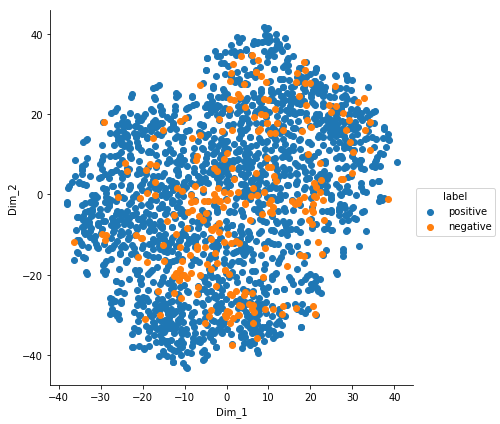

In [27]:
# TSNE
import seaborn as sn
from sklearn.manifold import TSNE

# Picking the top 2k points as TSNE takes a lot of time for 15K points
data_2000 = standardized_data_w2v[0:2000,:]
labels_2000 = labels[0:2000]

model = TSNE(n_components=2, random_state=0)

tsne_data_w2v = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data_w2v = np.vstack((tsne_data_w2v.T, labels_2000)).T
tsne_df_w2v = pd.DataFrame(data=tsne_data_w2v, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df_w2v, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

<b>Observation(s):-</b>

1. We observe in this t-sne plot that on taking 2k datapoints, both class label(positive class and negative class) data points are not that much clearly separable by which we cannot make model to classify both class datapoints.

2. And we also see that lot here is huge amount of data points of both classes between interval -40 to +40 on x-axis and y-axis are most of them overlapped. 

3. There by making it very diffcult in this case to classify probelm as most of the points of both class are overlapped and most of orange points are spreaded in between of blue points as randomly spreaded.


# (4) TF-IDF Weighted Word2Vec

In [17]:
# TF-IDF weighted Word2Vec

t=tf_idf_vect.get_feature_names()  # tfidf words/col-names

# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

t1=list()   # the tfidf-w2v for each sentence/review is stored in this list
r=0
for st in list_of_sent:  # for each review/sentence
    sv=np.zeros(50)      # as word vectors are of zero length
    ws=0;                # num of words with a valid vector in the sentence/review
    for wr in st:        # for each word in a review/sentence
        try:
            v=w2v_model.wv[wr]
            tfi=final_tf_idf[r,t.index(wr)]   # obtain the tf_idfidf of a word in a sentence/review
            sv += (v*tfi)
            ws += tfi
        except:
            pass
    sv /= ws
    t1.append(sv)
    r +=1
        

In [23]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import MaxAbsScaler
standardized_data_tfidfw2v = MaxAbsScaler().fit_transform(t1)
print(standardized_data_tfidfw2v.shape)

(5000, 50)


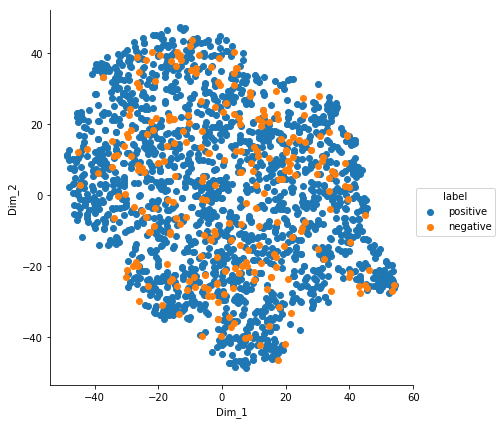

In [26]:
# TSNE
import seaborn as sn
from sklearn.manifold import TSNE

# Picking the top 2k points as TSNE takes a lot of time for 15K points
data_2000 = standardized_data_tfidfw2v[0:2000,:]
labels_2000 = labels[0:2000]

model = TSNE(n_components=2, random_state=0)

tsne_data_tfidfw2v = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data_tfidfw2v = np.vstack((tsne_data_tfidfw2v.T, labels_2000)).T
tsne_df_tfidfw2v = pd.DataFrame(data=tsne_data_tfidfw2v, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df_tfidfw2v, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

<b>Observation(s):-</b>

1. We observe in this t-sne plot that on taking 2k datapoints, both class label(positive class and negative class) data points are not that much clearly separable by which we cannot make model to classify both class datapoints.

2. And we also see that lot here is huge amount of data points of both classes between interval -40 to +60 on x-axis and y-axis are most of them overlapped. 

3. There by making it very diffcult in this case to classify probelm as most of the points of both class are overlapped and most of orange points are spreaded in between of blue points as randomly spreaded.


<b>Final Observation(s):-</b>

1. As we have seen all four techniques for featurization/vetorization (Bow, tf-idf, avg-word2vec, tf-idf weighted word2vec) neither of them can separate data points as clearlt as   it is needed to bulid our classification model for this Amazon fine food review dataset